In [1]:
import os

os.environ['DASHSCOPE_API_KEY'] = 'sk-e2a05bbcfac84e53b73f98acef15a009'

# Step 0: Define tools and model

from langchain_core.tools import tool
from langchain_community.chat_models.tongyi import ChatTongyi

llm = ChatTongyi(
    model="qwen-max",   # 此处以qwen-max为例，您可按需更换模型名称。模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
    streaming=True,
    # other params...
)

In [2]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [4]:
from typing import TypedDict
from IPython.core.display import Image
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

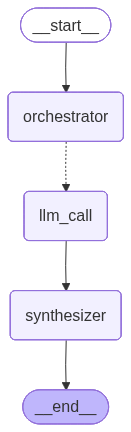

In [5]:

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])